### Scanned Document Classification using CNN

In [0]:
# Code to unzip the raw data
import tarfile
tar = tarfile.open("rvl-cdip.tar.gz")
tar.extractall()
tar.close()

In [0]:
import tensorflow as tf
from keras import backend as k
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
k.tensorflow_backend.set_session(tf.Session(config=config))
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import tarfile
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r
import time
import math
import cv2
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import log_loss,confusion_matrix
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,MaxPooling2D,Conv2D,Dropout,BatchNormalization
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.utils import np_utils
from keras.preprocessing import image
from sklearn.datasets import load_files
import cv2
import pickle
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,precision_score,recall_score
from statistics import mode
from sklearn.utils.multiclass import unique_labels
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import *
from keras.models import load_model
# Keras Utility to perform cyclic learning rate
!pip install gitpython
import  git
#git.Git("").clone("https://github.com/bckenstler/CLR.git") 
from CLR.clr_callback import *
import CLR.clr_callback as clr

Using TensorFlow backend.


In [0]:
# training config
classes = {'0': 'letter',
 '1': 'form',
 '10': 'budget',
 '11': 'invoice',
 '12': 'presentation',
 '13': 'questionnaire',
 '14': 'resume',
 '15': 'memo',
 '2': 'email',
 '3': 'handwritten',
 '4': 'advertisement',
 '5': 'scientific report',
 '6': 'scientific publication',
 '7': 'specification',
 '8': 'file folder',
 '9': 'news article'}

regions = ['Whole','header', 'footer', 'left_body', 'right_body']
classes_name=[v for (k,v) in classes.items()]
folders=[classes[str(i)] for i in range(16)]
clr_triangular = CyclicLR(mode='triangular2')

#### Pipeline Methods

In [0]:
# This function will create an index file with image paths and labels in csv format
# obtained csv will have two columns path(path to acess the image),label(class of the image)
def create_csv(file_path):
    """
    This function will create an index file with image paths and labels in csv format 
    obtained csv will have two columns path(path to acess the image),label(class of the image)
    """
    images=[]
    labels=[]
    label_file=pd.DataFrame(columns=['path','label'],index=None)
    file=open(file_path)
    for ele in file:
        images.append(ele.split(' ')[0])
        labels.append(ele.split(' ')[1].rstrip())
    label_file.path=images
    label_file.label=labels
    return label_file

def get_data_generator(path,batch_size):
    """
    This function will generate testing data on the flow as required.
    
    """
    datagen = ImageDataGenerator(
    rescale = 1./255,
    featurewise_std_normalization=True) 
    data_generator = datagen.flow_from_directory(
    path,
    target_size = (224,224),
    batch_size = batch_size, 
    class_mode = "categorical")
    return data_generator

def eval_model(model,test_generator,limit):
    """
   This function predicts the result of a candidate model
   test_generator : genertaor to evaluate
   model : candidate model
   limit: No of test samples to consider
    
    """
    x,y=test_generator.next()
    y_pred=[]
    y_true=[]
    count=0
    for i in range(len(x)):
        pred=model.predict(np.expand_dims(x[i], axis=0))
        predicted_y=np.argmax(pred)
        y_pred.append(predicted_y)
        y_true.append(np.argmax(y[i]))
        count+=1
        # limit the number of samples to be considered
        if(count==limit):
            break
    return y_pred,y_true

def eval_stacked_model(model1,model2,test_generator,limit):
    """
    This function creates an ensamble of candidate CNN models and predict the result
    model1,model2 -- candidate models
    test_generator -- Instance of ItemDataGenerator to randomly generate test data
    limit -- limits the number of test samples
    
    """
    try:
         x,y=test_generator.next()
    except:
        print('data loading failed.')
    y_pred=[]
    y_true=[]
    count=0
    for i in range(len(x)):
        pred1=model1.predict(np.expand_dims(x[i], axis=0))
        pred2=model2.predict(np.expand_dims(x[i], axis=0))
        try:
            # we will concatenate the predictions of two models
            predicted_y=np.argmax(pred1+pred2)
            y_pred.append(predicted_y)
        except:
            print('Some error occured.')
            y_pred.append(np.argmax(pred2))
        y_true.append(np.argmax(y[i]))
        count+=1
        # limit the number of samples to be considered
        if(count==limit):
            break
    return y_pred,y_true


def plot_confusion_matrix(test_y, predict_y):
    """
    This function plots the confusion matrix given predicted and actual values.
    """
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)    
    B =(C/C.sum(axis=0))
    labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(17,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(17,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(17,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

def preprocess_data(label_path,train_dir,test_dir,val_dir,num_val_samples,num_train_samples,img_width, img_height,batch_size,epochs,
    num_test_samples_generator,num_test_samples):
    """
    This methdod converts raw data in to preprocessed data.
    """
    train_label_path=label_path+'train.txt' 
    test_label_path=label_path+'test.txt' 
    val_label_path=label_path+'val.txt'
    # creating index file for train,test and val dataset
    train_label=create_csv(train_label_path)
    test_label=create_csv(test_label_path)
    val_label=create_csv(val_label_path)
    cv_dir=val_dir
	  # Creating train,validation and Test directories
    os.mkdir('train')
    os.mkdir('test')
    os.mkdir('val')
    for region in regions:
        if(os.path.exists('train/'+region)==False):
            os.mkdir('train/'+region)
        if(os.path.exists('val/'+region)==False):
            os.mkdir('val/'+region)
    for region in regions:
        for label in classes_name:
            if(os.path.exists('train/'+region+'/'+label)==False):
                os.mkdir('train/'+region+'/'+label)
            if(os.path.exists('val/'+region+'/'+label)==False):
                os.mkdir('val/'+region+'/'+label)
    for folder in folders:
        if(os.path.exists('test/'+folder)== False):
            os.mkdir('test/'+folder)
    for i in tqdm(range(len(test_label))):
        if(os.path.exists('images/'+test_label.iloc[i].path)):
            source='images/'+test_label.iloc[i].path
            dest='test/'+classes[str(test_label.iloc[i].label)]
        if(os.path.exists(dest+'/'+source.split('/')[-1])==False):
            shutil.move(source,dest)
    for i in tqdm(range(len(train_label))):
        if(os.path.exists('images/'+train_label.iloc[i].path)):
            source='images/'+train_label.iloc[i].path
            dest='train/Whole/'+classes[str(train_label.iloc[i].label)]
        if(os.path.exists(dest+'/'+source.split('/')[-1])==False):
            shutil.move(source,dest)
    for i in tqdm(range(len(val_label))):
        if(os.path.exists('images/'+val_label.iloc[i].path)):
            source='images/'+val_label.iloc[i].path
            dest='val/Whole/'+classes[str(val_label.iloc[i].label)]
        if(os.path.exists(dest+'/'+source.split('/')[-1])==False):
            shutil.move(source,dest)
    val_dir='val/Whole'
    count,limit=0,2000
    for folder in tqdm(os.listdir(val_dir)):
      #os.shuffle(val_dir+'/'+folder)
        for image in os.listdir(val_dir+'/'+folder):
            img = cv2.imread(val_dir+'/'+folder+'/'+image,0)
            height = img.shape[0]
            width = img.shape[1]
            header = img[0:(int(height*0.33)), 0:width]
            footer = img[int(height*0.67):height, 0:width]
            left_body = img[int(height*0.33):int(height*0.67), 0:int(width*0.5)]
            right_body = img[int(height*0.33):int(height*0.67), int(width*0.5):width]
            header_path='val/header/'+folder+'/'+image.split('/')[-1]
            footer_path='val/footer/'+folder+'/'+image.split('/')[-1]
            left_path='val/left_body/'+folder+'/'+image.split('/')[-1]
            right_path='val/right_body/'+folder+'/'+image.split('/')[-1]
            if(os.path.exists(header_path)==False):
                cv2.imwrite(header_path, header)
            if(os.path.exists(footer_path)==False):
                cv2.imwrite(footer_path, footer)
            if(os.path.exists(left_path)==False):
                cv2.imwrite(left_path, left_body)
            if(os.path.exists(right_path)==False):
                cv2.imwrite(right_path, right_body)
            count+=1
            if(count==limit):
                break
    train_dir='train/Whole'
    count,limit=0,2000
    for folder in tqdm(os.listdir(train_dir)):
      #os.shuffle(train_dir+'/'+folder)
      count=0
      for image in os.listdir(train_dir+'/'+folder):
          img = cv2.imread(train_dir+'/'+folder+'/'+image,0)
          height = img.shape[0]
          width = img.shape[1]
          header = img[0:(int(height*0.33)), 0:width]
          footer = img[int(height*0.67):height, 0:width]
          left_body = img[int(height*0.33):int(height*0.67), 0:int(width*0.5)]
          right_body = img[int(height*0.33):int(height*0.67), int(width*0.5):width]
          header_path='train/header/'+folder+'/'+image.split('/')[-1]
          footer_path='train/footer/'+folder+'/'+image.split('/')[-1]
          left_path='train/left_body/'+folder+'/'+image.split('/')[-1]
          right_path='train/right_body/'+folder+'/'+image.split('/')[-1]
          if(os.path.exists(header_path)==False):
              cv2.imwrite(header_path, header)
          if(os.path.exists(footer_path)==False):
              cv2.imwrite(footer_path, footer)
          if(os.path.exists(left_path)==False):
              cv2.imwrite(left_path, left_body)
          if(os.path.exists(right_path)==False):
              cv2.imwrite(right_path, right_body)
          count+=1
          if(count==limit):
              break
    print('[Info]Total No of folders present in Train:',len(os.listdir(train_dir)))
    print('[Info]Total No of folders present in Test:',len(os.listdir(test_dir)))
    print('[Info]Total No of folders present in Val:',len(os.listdir(val_dir)))

def train(train_dir,test_dir,val_dir,num_val_samples,num_train_samples,img_width, img_height,batch_size,epochs,
    num_test_samples_generator,num_test_samples):
    """
    Method to train the models(CNN and InceptionResNetv2).
    """
    train_datagen = ImageDataGenerator(
    rescale = 1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=13,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2)
    val_datagen = ImageDataGenerator(
    rescale = 1./255,
    featurewise_std_normalization=True)
    train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size, 
    class_mode = "categorical")
    val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size, 
    class_mode = "categorical")
    model1=applications.InceptionResNetV2(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3)) 
    x = model1.output
    x=Dropout(0.5)(x)
    x = Flatten()(x)
    output = Dense(num_classes, activation="softmax")(x)
    model1 = Model(input = model.input, output = output)
    model1.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])
    reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=3, min_lr=0.0001,mode='auto')
    checkpoint = ModelCheckpoint("vgg16.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=3, min_lr=0.0001,mode='auto')
    callbacks=[checkpoint,clr_triangular]
    history=model1.fit_generator(train_generator,samples_per_epoch =10000,
    epochs = 50,validation_data = val_generator,validation_steps =math.ceil(10000//(batch_size)),callbacks=callbacks,verbose=1)
    model1.save('vgg16.h5')
    checkpoint = ModelCheckpoint("inceptionresnet.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    history=model2.fit_generator(train_generator,samples_per_epoch =10000,
    epochs = 50,validation_data = val_generator,validation_steps =math.ceil(10000//(batch_size)),callbacks=callbacks,verbose=1)
    model2.save('inceptionresnet.h5')
    return model1,model2

In [0]:

def final(label_path,train_dir,test_dir,val_dir,num_val_samples,num_train_samples,img_width, img_height,batch_size,epochs,
    num_test_samples_generator,num_test_samples,model1_path='vgg16.h5',model2_path='inceptionresnetv2.h5',skip_training=True,skip_preprocess=False):  
    """
    This function will take all the necessary inputs and implement the  pipeline
    label_path : path of the training lables
	  train_dir,test_dir,val_dir: path of the train,test and validation data
	  num_val_samples: number of validation samples
	  num_train_samples:number of training samples
	  img_width:width of image
	  img_height: height of image
	  batch_size: size of training batches
	  epochs: Number of epochs
    num_test_samples_generator: number of samples to generate test  data
	  num_test_samples: number of samples used for evaluation
	  model1_path: path of trained model, model1.Default value 'vgg16.h5'
	  model2_path: path of trained model, model2.Default value 'inceptionresnetv2.h5'
	  skip_training: Flag to skip the training process, default value False
    """ 
    print('--------------Document Classification Process Pipeline-------------')
    # preprocess data
    if(skip_preprocess==False):
        print('[info] Data preprocess Initiated..')
        preprocess_data(label_path,train_dir,test_dir,val_dir,num_val_samples,num_train_samples,img_width, img_height,batch_size,epochs,
        num_test_samples_generator,num_test_samples)
        print('[info] Data preprocessed Sucessfully.')
    else:
        print('[info] Data is already preprocessed.Skipping Preprocessing..')
    # Model Training
    if(skip_training==False):
      print('[info] Model Training Initiated..')
      model1,model2=train(train_dir,test_dir,val_dir,num_val_samples,num_train_samples,img_width, img_height,batch_size,epochs,
      num_test_samples_generator,num_test_samples)
      print('[info] Model Training Completed Sucessfully.')
    else:
      model1=load_model(model1_path)
      model2=load_model(model2_path)
      print('[info] Training Skipped. Trained Model Loaded Sucessfully.')
    # Test Data Generation
    print('[info] Preraring Test Data..')
    test_datagen = ImageDataGenerator(rescale = 1./255,featurewise_std_normalization=True)
    test_generator = test_datagen.flow_from_directory(test_dir,target_size = (img_height, img_width),
	  batch_size = num_test_samples_generator,shuffle='True',class_mode = "categorical")
    train_datagen = ImageDataGenerator(rescale = 1./255,featurewise_std_normalization=True)
    train_generator = train_datagen.flow_from_directory(train_dir,target_size = (img_height, img_width),
	  batch_size = 2500,shuffle='True',class_mode = "categorical")
    val_datagen = ImageDataGenerator(rescale = 1./255,featurewise_std_normalization=True)
    val_generator = val_datagen.flow_from_directory(val_dir,target_size = (img_height, img_width),
	  batch_size = 2500,shuffle='True',class_mode = "categorical")
    # Performance Evaluation
    print('[info] Performance Evaluation Initiated...')
    print('[info] Evaluating Train Data...')
    y_pred_tr,y_true_tr=eval_stacked_model(model1,model2,train_generator,num_test_samples)
    accuracy_tr=np.round(accuracy_score(y_pred_tr,y_true_tr),3)
    print('[info] Evaluating Val Data...')
    y_pred_val,y_true_val=eval_stacked_model(model1,model2,val_generator,num_test_samples)
    accuracy_val=np.round(accuracy_score(y_pred_val,y_true_val),3)
    print('[info] Evaluating Test Data...')
    y_pred,y_true=eval_stacked_model(model1,model2,test_generator,num_test_samples)
    accuracy=np.round(accuracy_score(y_pred,y_true),3)
    f1=np.round(f1_score(y_pred,y_true,average='macro'),3)
    precision=np.round(precision_score(y_pred,y_true,average='macro'),3)
    recall=np.round(recall_score(y_pred,y_true,average='macro'),3)
    print('-----Model Performance(Test Data)------')
    print('[info] Train Accuracy:',round((accuracy_tr)*100,3),'%')
    print('[info] Val Accuracy:',round((accuracy_val)*100,3),'%')
    print('[info] Test Accuracy:',round((accuracy)*100,3),'%')
    print('[info] Macro F1 Score:',round(f1,2))
    print('[info] Precision Score:',round(precision,3))
    print('[info] Recall Score:',round(recall,3))
    x=['Accuracy Score','F1 Score','Precision','Recall']
    #y=[accuracy,f1,precision,recall]
    y=[round((accuracy),3),round(f1,3),round(precision,3),round(recall,3)]
    sns.barplot(x,y)
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.yticks([0,0.3,0.6,0.9])
    plt.title('Model Performance')
    plt.show()  
    y=['Train Accuracy','Val Accuracy','Test Accuracy']
    #y=[accuracy,f1,precision,recall]
    x=[round((accuracy_tr)*100,2),round((accuracy_val)*100,2),round((accuracy)*100,2)]
    sns.barplot(x,y)
    plt.xlabel('Score')
    plt.title('Model Performance on Train, Val and Test Data')
    plt.show()  
    plot_confusion_matrix(y_true,y_pred)
    print('Performance Evaluation completed Sucssfully.')

#### Import Trained Models

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Copying models from gdrive local directory
model1_path='drive/My Drive/vgg_04_12_2019.h5'
model2_path='drive/My Drive/Models/resinception_12_11_2019.h5'
!cp model1_path 'vgg16.h5'
!cp  model2_path 'inceptionresnetv2.h5'

#### Pipeline Configuration

In [0]:
# Configuration
label_path='labels/'
img_width, img_height = 224,224
train_dir = "train/Whole"
val_dir = "val/Whole"
test_dir="test"
num_train_samples = 320000
num_val_samples = 40000 
batch_size = 50
epochs = 20
num_classes=16
num_test_samples_generator,num_test_samples=10000,10000

#### Execution

--------------Document Classification Process Pipeline-------------
[info] Data is already preprocessed.Skipping Preprocessing..
[info] Training Skipped. Trained Model Loaded Sucessfully.
[info] Preraring Test Data..
Found 39997 images belonging to 16 classes.
Found 319837 images belonging to 16 classes.
Found 39995 images belonging to 16 classes.
[info] Performance Evaluation Initiated...
[info] Evaluating Train Data...
[info] Evaluating Val Data...
[info] Evaluating Test Data...
-----Model Performance(Test Data)------
[info] Train Accuracy: 96.8 %
[info] Val Accuracy: 92.06 %
[info] Test Accuracy: 91.57 %
[info] Macro F1 Score: 0.92
[info] Precision Score: 0.915
[info] Recall Score: 0.916


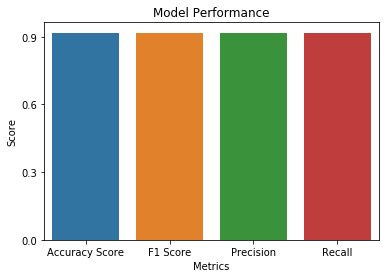

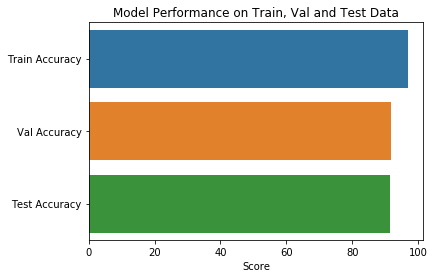

-------------------------------------------------- Confusion matrix --------------------------------------------------


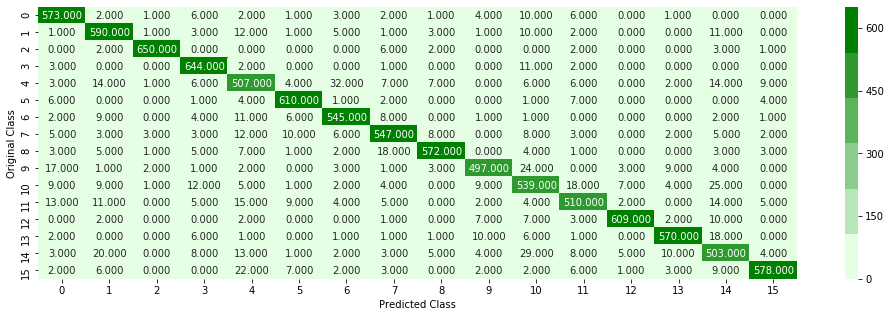

-------------------------------------------------- Precision matrix --------------------------------------------------


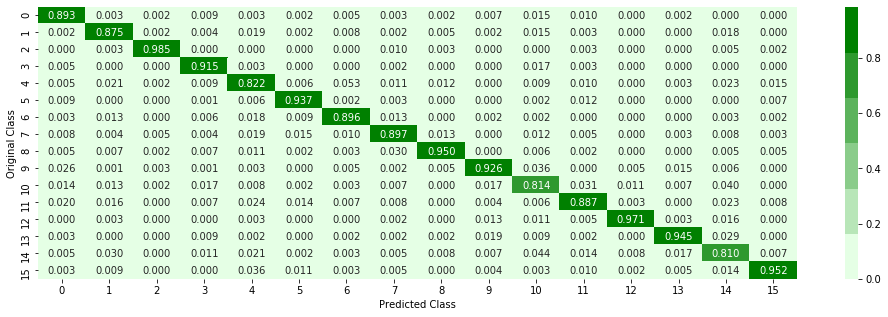

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


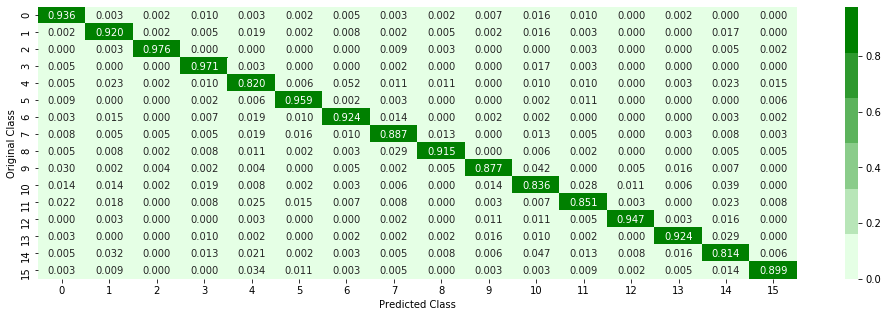

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Performance Evaluation completed Sucssfully.


In [0]:
final(label_path,train_dir,test_dir,val_dir,num_val_samples,num_train_samples,
img_width, img_height,batch_size,epochs,num_test_samples_generator,num_test_samples,model1_path='vgg16.h5',
model2_path='inceptionresnetv2.h5',skip_training=True,skip_preprocess=True)